**Edric Tam Report -----The Fat Boys**

We performed the following in this document for both local intensity and integrated intensity. 
Overall, integrated intensity yielded much more beautiful results. 
1. Additional filtering based on low DAPI and high Synapsin and only look at the excitatory/inhibitory markers ignoring the rest
2. Correlation Matrix
3. Hierarchical Clustering
4. PCA (with artificial generated labels)
5. K-means clustering
6. Spectral clustering

Future Directions:

1. Look at other features in addition to local and integrated brightness
2. Look at other markers in addition to just the excitatory and inhibitory markers

In [ ]:
# load all necessary dependencies and load in the log transformed data 
# for both integrated and local intensity

import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pickle

from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


N = 1000 # number of samples at each iteration

dataFile = open('local_processed.p')
localData = pickle.load(dataFile)
dataFile = open('integrated_processed.p')
integratedData = pickle.load(dataFile)

In [70]:
markers = ['Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI']
synapType = ['synap','synap','ex.pre','ex.pre','ex.pre','in.pre',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','other','other',
                  'other','other','other','other','none','none']


# filter synapses such that only the ones with high synapsin expression will be accepted.
avglocSynap1 = np.mean(localData[1])
avgintSynap1 = np.mean(integratedData[1])

intfilteredSynapse1 = [synapse for synapse, value in enumerate(integratedData[1]) if value > avgintSynap1]
locfilteredSynapse1 = [synapse for synapse, value in enumerate(localData[1]) if value > avglocSynap1]   
filteredSynapses1 = list(set(intfilteredSynapse1).intersection(locfilteredSynapse1))

avglocSynap2 = np.mean(localData[2])
avgintSynap2 = np.mean(integratedData[2])

intfilteredSynapse2 = [synapse for synapse, value in enumerate(integratedData[2]) if value > avgintSynap2]
locfilteredSynapse2 = [synapse for synapse, value in enumerate(localData[2]) if value > avglocSynap2] 
filteredSynapses2 = list(set(intfilteredSynapse2).intersection(locfilteredSynapse2))

filteredSynapses = list(set(filteredSynapses1).intersection(filteredSynapses2))

# filter away synapses such that those with high tubulin expression will not be accepted

avgloctub = np.mean(localData[24])
avginttub = np.mean(integratedData[24])

intfilteredtub = [synapse for synapse, value in enumerate(integratedData[24]) if value < avginttub]
locfilteredtub = [synapse for synapse, value in enumerate(localData[24]) if value < avgloctub]   
filteredtub = list(set(intfilteredtub).intersection(locfilteredtub))

finalFilteredInd = list(set(filteredSynapses).intersection(filteredtub))

# now that we have the valid synapses, we only want certain features...
# i.e. the inhibitory and the excitatory ones

exAndInMarkerInd = [i for i,j in enumerate(synapType) if j[0:2] == 'in' or j[0:2]=='ex']

# finalized filtered data
filteredIntData =  np.asarray([integratedData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))
filteredLocData =  np.asarray([localData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))


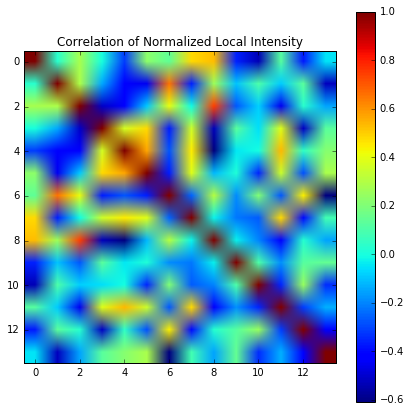

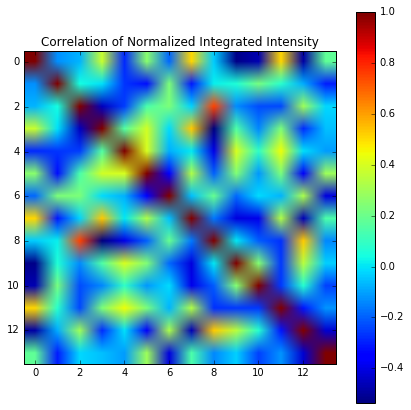

In [99]:
np.random.seed(1)  # for reproducibility, set random seed
randPermute = np.random.permutation(range(0,len(finalFilteredInd)))
randSample = randPermute[0:N]

locFeatures = filteredLocData[randSample,:]
intFeatures = filteredIntData[randSample,:]

r = len(exAndInMarkerInd)

%matplotlib inline

corrLocal = np.empty([r,r])
for i in range(0,r):
    for j in range(0,r):
        results = np.corrcoef(locFeatures[i,:],locFeatures[j,:])
        corrLocal[i,j] = results[1,0]

plt.figure(figsize=(7,7))
plt.imshow(corrLocal)
plt.title('Correlation of Normalized Local Intensity')
plt.colorbar()
plt.show()

corrIntegrated = np.empty([r,r])
for i in range(0,r):
    for j in range(0,r):
        results = np.corrcoef(intFeatures[i,:],intFeatures[j,:])
        corrIntegrated[i,j] = results[1,0]
        
plt.figure(figsize=(7,7))
plt.imshow(corrIntegrated)
plt.title('Correlation of Normalized Integrated Intensity')
plt.colorbar()
plt.show()

In [149]:
#locLabels = [for i in locLabels[:,]]
#intLabels = 
meanVGlut1Loc = np.mean(locFeatures[:,0])
VGlut1PosLoc = [locFeatures[i,0] > meanVGlut1Loc for i in range(0,len(locFeatures[:,0]))]
g = lambda x: 1 if x else 0
VGlut1LocLabel = [g(i) for i in VGlut1PosLoc]
meanVGlut1Int = np.mean(intFeatures[:,0])
VGlut1PosInt = [intFeatures[i,0] > meanVGlut1Int for i in range(0,len(intFeatures[:,0]))]
VGlut1IntLabel = [g(i) for i in VGlut1PosInt]

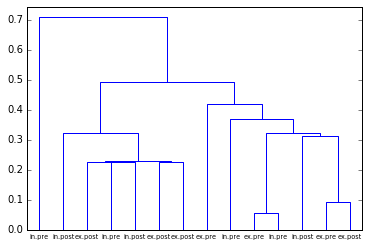

In [140]:
import hcluster
import scipy.cluster.hierarchy as sch
markerlabels = [markers[i] for i in exAndInMarkerInd]
typelabels = [synapType[i] for i in exAndInMarkerInd]
Z=sch.linkage(corrLocal, 'single', 'correlation')
localDendro = sch.dendrogram(Z, color_threshold=0, labels=typelabels,leaf_font_size=6.5)

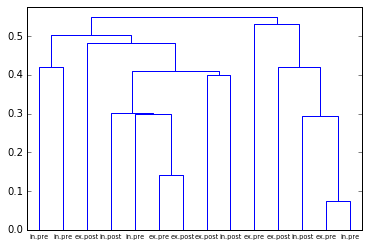

In [141]:
Y=sch.linkage(corrIntegrated, 'single', 'correlation')
integratedDendro = sch.dendrogram(Y, color_threshold=0, labels=typelabels,leaf_font_size=6.5)

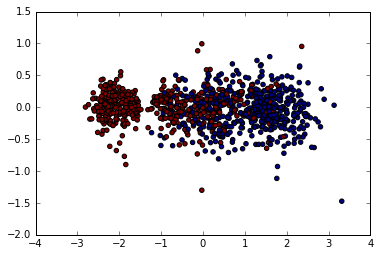

In [178]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(locFeatures[1:100,:])
localPCA = pca.transform(locFeatures)

import pylab as pl
pl.scatter(localPCA[:, 0], localPCA[:, 1], c=VGlut1LocLabel) 

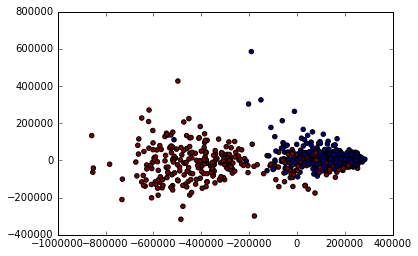

In [177]:
pca = decomposition.PCA(n_components=3)
pca.fit(intFeatures[1:100,:])
integratedPCA = pca.transform(intFeatures)

pl.scatter(integratedPCA[:, 0], integratedPCA[:, 1], c=VGlut1IntLabel)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 999


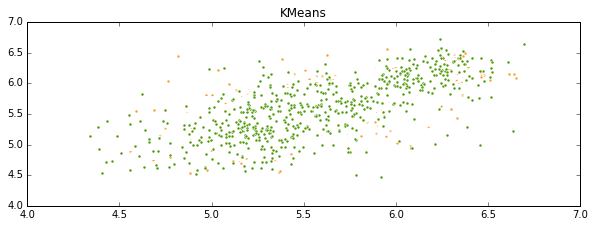

In [176]:
from sklearn.cluster import KMeans

KM = KMeans(init='k-means++', n_clusters=2)
KM.fit(locFeatures[1:1000,:])

k_means_labels = KM.labels_
k_means_cluster_centers = KM.cluster_centers_

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#FF9C34', '#4E9A06']

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(2), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(locFeatures[my_members, 0], locFeatures[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    
ax.set_title('KMeans')


/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 999


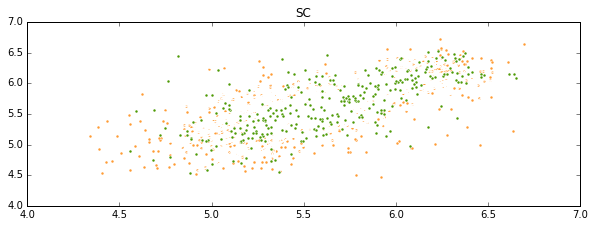

In [175]:
from sklearn.cluster import SpectralClustering

SC = SpectralClustering(n_clusters=2)
SC.fit(locFeatures[1:1000,:])

SC_labels = SC.labels_

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#FF9C34', '#4E9A06']

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(2), colors):
    my_members = SC_labels == k
    ax.plot(locFeatures[my_members, 0], locFeatures[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    
ax.set_title('SC')